# Network Analysis

Chapter 21 of [Data Science from Scratch](http://shop.oreilly.com/product/0636920033400.do). Joel's code: [network_analysis.py](https://github.com/joelgrus/data-science-from-scratch/blob/master/code-python3/network_analysis.py)

In [1]:
import networkx as nx
import matplotlib.pyplot as plt

In [123]:
from collections import deque
from functools import partial
import os
import random
import sys

In [91]:
book_dir = '/Users/CBare/Documents/projects/data-science-from-scratch'
sys.path.extend(os.path.join(book_dir, 'chapter_{:02d}'.format(i)) for i in [3,4,5,6,7,8])

In [129]:
from vector import dot, magnitude, scalar_multiply, distance
from matrix import make_matrix, shape, get_row, get_column

## Build friendship graph

In [98]:
users = [
        { "id": 0, "name": "Hero" },
        { "id": 1, "name": "Dunn" },
        { "id": 2, "name": "Sue" },
        { "id": 3, "name": "Chi" },
        { "id": 4, "name": "Thor" },
        { "id": 5, "name": "Clive" },
        { "id": 6, "name": "Hicks" },
        { "id": 7, "name": "Devin" },
        { "id": 8, "name": "Kate" },
        { "id": 9, "name": "Klein" }
    ]

In [99]:
friendships = [(0, 1), (0, 2), (1, 2), (1, 3), (2, 3), (3, 4),
               (4, 5), (5, 6), (5, 7), (6, 8), (7, 8), (8, 9)]

In [100]:
for user in users:
    user["friends"] = []

In [101]:
for i, j in friendships:
    # this works because users[i] is the user whose id is i
    users[i]["friends"].append(users[j]) # add i as a friend of j
    users[j]["friends"].append(users[i]) # add j as a friend of i

In [145]:
G = nx.Graph()
G.add_edges_from([(users[i]['name'], users[j]['name']) for i,j in friendships])

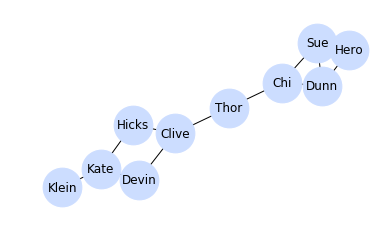

In [146]:
pos=nx.spring_layout(G, k=3, iterations=500)
nx.draw_networkx_labels(G, pos=pos)
nx.draw(G, pos, node_size=1500, node_color='#ccddff')
plt.show()

## Betweenness Centrality

In [104]:
def shortest_paths_from(from_user):
    
    # a dictionary from "user_id" to *all* shortest paths to that user
    shortest_paths_to = { from_user["id"] : [[]] }
    
    # a queue of (previous user, next user) that we need to check.
    # starts out with all pairs (from_user, friend_of_from_user)
    frontier = deque((from_user, friend) for friend in from_user["friends"])
    
    # keep going until we empty the queue
    while frontier:
        prev_user, user = frontier.popleft()
        user_id = user["id"]
        
        # because of the way we're adding to the queue,
        # necessarily we already know some shortest paths to prev_user
        paths_to_prev_user = shortest_paths_to[prev_user["id"]]
        new_paths_to_user = [path + [user_id] for path in paths_to_prev_user]
        
        # it's possible we already know a shortest path
        old_paths_to_user = shortest_paths_to.get(user_id, [])
        
        # what's the shortest path to here that we've seen so far?
        if old_paths_to_user:
            min_path_length = len(old_paths_to_user[0])
        else:
            min_path_length = float('inf')

        # only keep paths that aren't too long and are actually new
        new_paths_to_user = [path
                             for path in new_paths_to_user
                             if len(path) <= min_path_length
                             and path not in old_paths_to_user]

        shortest_paths_to[user_id] = old_paths_to_user + new_paths_to_user
        
        # add never-seen neighbors to the frontier
        frontier.extend((user, friend)
                        for friend in user["friends"]
                        if friend["id"] not in shortest_paths_to)
    
    return shortest_paths_to

In [105]:
for user in users:
    user["shortest_paths"] = shortest_paths_from(user)

In [106]:
for user in users:
    user["betweenness_centrality"] = 0.0

In [107]:
for source in users:
    source_id = source["id"]
    for target_id, paths in source["shortest_paths"].items():
        if source_id < target_id:
            num_paths = len(paths)
            contrib = 1 / num_paths
            for path in paths:
                for id in path:
                    if id not in [source_id, target_id]:
                        users[id]["betweenness_centrality"] += contrib

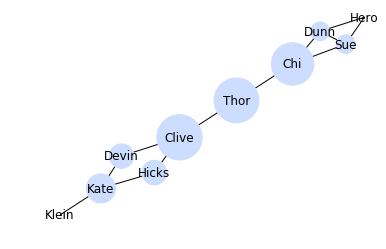

In [108]:
pos=nx.spring_layout(G, k=3, iterations=500)
nx.draw_networkx_labels(G, pos=pos)
nx.draw(G, pos, 
        node_size=[user["betweenness_centrality"]*100 for user in users],
        node_color='#ccddff')
plt.show()

In [109]:
def farness(user):
    """the sum of the lengths of the shortest paths to each other user"""
    return sum(len(paths[0]) for paths in user["shortest_paths"].values())

In [134]:
for user in users:
    user["closeness_centrality"] = 1 / farness(user)
    print(user["closeness_centrality"])

0.029411764705882353
0.037037037037037035
0.037037037037037035
0.045454545454545456
0.05
0.05
0.041666666666666664
0.041666666666666664
0.03571428571428571
0.027777777777777776


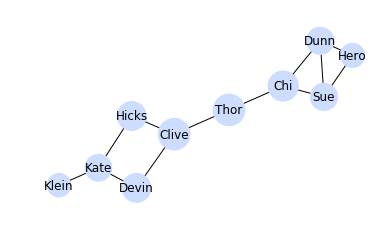

In [111]:
pos=nx.spring_layout(G, k=3, iterations=500)
nx.draw_networkx_labels(G, pos=pos)
nx.draw(G, pos, 
        node_size=[user["closeness_centrality"]*20000 for user in users],
        node_color='#ccddff')
plt.show()

## Eigenvector Centrality

In [112]:
def matrix_product_entry(A, B, i, j):
    return dot(get_row(A, i), get_column(B, j))

In [113]:
def matrix_multiply(A, B):
    n1, k1 = shape(A)
    n2, k2 = shape(B)
    if k1 != n2:
        raise ArithmeticError("incompatible shapes!")
    return make_matrix(n1, k2, partial(matrix_product_entry, A, B))

In [114]:
def vector_as_matrix(v):
    """returns the vector v (represented as a list) as a n x 1 matrix"""
    return [[v_i] for v_i in v]

In [115]:
def vector_from_matrix(v_as_matrix):
    """returns the n x 1 matrix as a list of values"""
    return [row[0] for row in v_as_matrix]

In [116]:
def matrix_operate(A, v):
    v_as_matrix = vector_as_matrix(v)
    product = matrix_multiply(A, v_as_matrix)
    return vector_from_matrix(product)

In [117]:
def find_eigenvector(A, tolerance=0.00001):
    guess = [random.random() for __ in A]
    
    while True:
        result = matrix_operate(A, guess)
        length = magnitude(result)
        next_guess = scalar_multiply(1/length, result)
        
        if distance(guess, next_guess) < tolerance:
            return next_guess, length

        guess = next_guess

In [118]:
def entry_fn(i, j):
    return 1 if (i, j) in friendships or (j, i) in friendships else 0

In [119]:
n = len(users)
adjacency_matrix = make_matrix(n, n, entry_fn)

In [130]:
eigenvector_centralities, mag = find_eigenvector(adjacency_matrix)

In [133]:
eigenvector_centralities

[0.38578065355490737,
 0.5147894164208267,
 0.5147894164208267,
 0.4733139761502962,
 0.23360777512937358,
 0.1501502232770493,
 0.08355234191411715,
 0.08355234191411715,
 0.07284433109294355,
 0.027293120079348518]

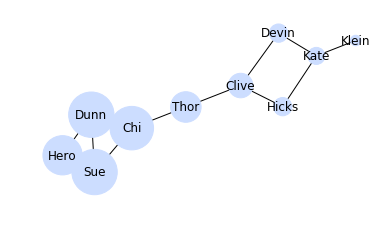

In [139]:
pos=nx.spring_layout(G, k=3, iterations=500)
nx.draw_networkx_labels(G, pos=pos)
nx.draw(G, pos, 
        node_size=[ec*4000 for ec in eigenvector_centralities],
        node_color='#ccddff')
plt.show()

## PageRank

In [143]:
endorsements = [(0, 1), (1, 0), (0, 2), (2, 0), (1, 2),
                (2, 1), (1, 3), (2, 3), (3, 4), (5, 4),
                (5, 6), (7, 5), (6, 8), (8, 7), (8, 9)]

In [141]:
for user in users:
    user["endorses"] = []
    user["endorsed_by"] = []

In [142]:
for source_id, target_id in endorsements:
    users[source_id]["endorses"].append(users[target_id])
    users[target_id]["endorsed_by"].append(users[source_id])

In [147]:
G = nx.DiGraph()
G.add_edges_from([(users[i]['name'], users[j]['name']) for i,j in endorsements])

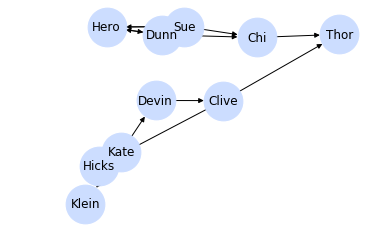

In [165]:
pos=nx.spring_layout(G, k=3, iterations=600)
nx.draw_networkx_labels(G, pos=pos)
nx.draw(G, pos, node_size=1500, node_color='#ccddff')
plt.show()

In [168]:
endorsements_by_id = [(user["id"], len(user["endorsed_by"])) for user in users]

In [176]:
sorted(endorsements_by_id, key=lambda e: e[1], reverse=True)

[(0, 2),
 (1, 2),
 (2, 2),
 (3, 2),
 (4, 2),
 (5, 1),
 (6, 1),
 (7, 1),
 (8, 1),
 (9, 1)]

In [177]:
def page_rank(users, damping = 0.85, num_iters = 100):

    # initially distribute PageRank evenly
    num_users = len(users)
    pr = { user["id"] : 1 / num_users for user in users }
    
    # this is the small fraction of PageRank
    # that each node gets each iteration
    base_pr = (1 - damping) / num_users
    
    for __ in range(num_iters):
        next_pr = { user["id"] : base_pr for user in users }
        for user in users:
            # distribute PageRank to outgoing links
            links_pr = pr[user["id"]] * damping
            for endorsee in user["endorses"]:
                next_pr[endorsee["id"]] += links_pr / len(user["endorses"])
        pr = next_pr

    return pr

In [185]:
pr = page_rank(users, num_iters=100)
pr

{0: 0.0404553415061296,
 1: 0.044921190893169885,
 2: 0.044921190893169885,
 3: 0.0404553415061296,
 4: 0.06785083675770529,
 5: 0.04344422700587085,
 6: 0.03346379647749512,
 7: 0.03346379647749512,
 8: 0.04344422700587085,
 9: 0.03346379647749512}

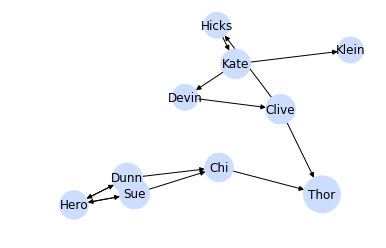

In [229]:
pos=nx.spring_layout(G, k=4, iterations=500)
nx.draw_networkx_labels(G, pos=pos)
nx.draw(G, pos,
        node_size=[pr[key]*20000 for key in pr],
        node_color='#ccddff')
plt.show()